In [42]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as model_util
import model.profile_models as profile_models
import model.train_profile_model as train_profile_model
import feature.util as feature_util
import feature.make_profile_dataset as make_profile_dataset
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import scipy.special
import sklearn
import matplotlib.pyplot as plt

### Define paths for the model and data of interest

In [4]:
# Define the paths to the peak BEDs and profile BigWigs
base_path = "/users/amtseng/tfmodisco/data/interim/ENCODE/"

peaks_bed = os.path.join(base_path, "SPI1/SPI1_ENCSR000BGW_K562_peakints.bed.gz")

prof_bigwigs = [
    (os.path.join(base_path, e_1), os.path.join(base_path, e_2))
    for e_1, e_2 in [
        ("SPI1/SPI1_ENCSR000BGQ_GM12878_neg.bw",
        "SPI1/SPI1_ENCSR000BGQ_GM12878_pos.bw"),
        ("SPI1/SPI1_ENCSR000BGW_K562_neg.bw",
        "SPI1/SPI1_ENCSR000BGW_K562_pos.bw"),
        ("SPI1/SPI1_ENCSR000BIJ_GM12891_neg.bw",
        "SPI1/SPI1_ENCSR000BIJ_GM12891_pos.bw"),
        ("SPI1/SPI1_ENCSR000BUW_HL-60_neg.bw",
        "SPI1/SPI1_ENCSR000BUW_HL-60_pos.bw"),
        ("SPI1/control_ENCSR000BGG_K562_neg.bw",
        "SPI1/control_ENCSR000BGG_K562_pos.bw"),
        ("SPI1/control_ENCSR000BGH_GM12878_neg.bw",
        "SPI1/control_ENCSR000BGH_GM12878_pos.bw"),
        ("SPI1/control_ENCSR000BIH_GM12891_neg.bw",
        "SPI1/control_ENCSR000BIH_GM12891_pos.bw"),
        ("SPI1/control_ENCSR000BVU_HL-60_neg.bw",
        "SPI1/control_ENCSR000BVU_HL-60_pos.bw")
    ]
]
num_tasks = int(len(prof_bigwigs) / 2)
# Path to saved model
model_path = "/users/amtseng/tfmodisco/models/trained_models/SPI1/2/model_ckpt_epoch_3.h5"

### Data preparation
Use classes from `make_profile_dataset` to prepare positive and negative inputs.

In [6]:
# Define some constants
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
input_length = 1346
profile_length = 1000
num_tasks = 4

In [7]:
# Maps coordinates to 1-hot encoded sequence
coords_to_seq = feature_util.CoordsToSeq(reference_fasta, center_size_to_use=input_length)

# Maps coordinates to profiles, in order of BigWigs given in `prof_bigwigs`
coords_to_vals_list = [
    (
        make_profile_dataset.CoordsToVals(path_1, profile_length),
        make_profile_dataset.CoordsToVals(path_2, profile_length)
    )
    for path_1, path_2 in prof_bigwigs
]
def coords_to_profs(coords):
    return np.stack([
        np.stack([ctv_1(coords), ctv_2(coords)], axis=1)
        for ctv_1, ctv_2 in coords_to_vals_list
    ], axis=1)

In [71]:
# Maps many coordinates to inputs sequences and profiles for the network
def coords_to_network_inputs(coords):
    input_seq = coords_to_seq(coords)
    profs = coords_to_profs(coords)
    return input_seq, profs

In [9]:
# Import set of positive peaks
pos_coords_table = pd.read_csv(peaks_bed, sep="\t", header=None, compression="gzip")

In [10]:
# Negative coordinate sampling
neg_coord_sampler = make_profile_dataset.GenomeIntervalSampler(chrom_sizes, input_length)

### Predicting and plotting profiles

In [13]:
# Import the model
custom_objects = {
    "tf": tf,
    "profile_loss": train_profile_model.get_profile_loss_function(num_tasks, profile_length),
    "count_loss": train_profile_model.get_count_loss_function(num_tasks)
}
model = keras.models.load_model(model_path, custom_objects=custom_objects)

In [70]:
def predict_coords(coords):
    """
    Fetches the necessary data from the given coordinate and runs it through the
    network. Returns the network predictions AND the true values from the dataset.
    The returned profiles are in terms of raw counts, and the returned counts are
    also raw. Returned values are all NumPy arrays.
    """
    input_seq, profiles = coords_to_network_inputs(coords)
    
    # Make length come before strands in profiles
    profiles = np.transpose(profiles, [0, 1, 3, 2])

    true_profs = profiles[:, :num_tasks, :, :]
    cont_profs = profiles[:, num_tasks:, :, :]

    # Run through the model
    logit_pred_profs, log_pred_counts = model.predict([input_seq, cont_profs])
    
    # Convert logit profile predictions to probabilities
    pred_prof_probs = scipy.special.softmax(logit_pred_profs, axis=2)
    
    # Convert log counts to counts
    pred_counts = np.exp(log_pred_counts) - 1
    
    # Convert profile probabilities to profile counts
    pred_profs = pred_prof_probs * np.expand_dims(pred_counts, 2)
    
    # Add true profiles to get true counts
    true_counts = np.sum(true_profs, axis=2)
    
    return pred_profs, pred_counts, true_profs, true_counts

In [28]:
def plot_profiles(pred_profs, true_profs, normalize=True, title=None):
    """
    Plots the given profiles.
    Both arguments should be T x O x 2 NumPy arrays, where the subarrays are the
    tracks for the plus and minus strand, for each task.
    If `normalize` is True, normalize the profiles to be probabilities (i.e.
    each track sums to 1)
    """
    num_tasks, prof_length = pred_profs.shape[0], pred_profs.shape[1]
    if normalize:
        pred_profs = pred_profs / np.expand_dims(np.sum(pred_profs, axis=1), axis=1)
        true_profs = true_profs / np.expand_dims(np.sum(true_profs, axis=1), axis=1)
    fig, ax = plt.subplots(num_tasks, figsize=(15, 20))
    for i in range(num_tasks):
        ax[i].plot(pred_profs[i,:,0], color="royalblue")
        ax[i].plot(-pred_profs[i,:,1], color="darkorange")
        ax[i].plot(true_profs[i,:,0], color="royalblue", alpha=0.5)
        ax[i].plot(-true_profs[i,:,1], color="darkorange", alpha=0.5)
    if title:
        fig.suptitle(title)

### Performance metrics

In [101]:
def profile_multinomial_nll(
    true_prof_counts, pred_prof_probs, true_total_counts
):
    """
    Computes the multinomial negative log likelihood of the true profiles, given
    the probabilties of the predicted profile.
    Arguments:
        `true_prof_counts`: N x T x O x 2 array, where N is the number of
            examples, T is the number of tasks, and O is the output profile
            length; contains the true profiles for each for each task and
            strand, as RAW counts
        `pred_prof_probs`: a N x T x O x 2 array, containing the predicted
            profiles for each task and strand, as PROBABILITIES
        `true_total_counts`: a N x T x 2 array, containing the true counts for
            each task and strand
    Returns an array of T items, containing the negative log likelihoods,
    averaged across the pooled strands and examples, for each task.
    """
    # Multinomial probability = n! / (x1!...xk!) * p1^x1 * ... pk^xk
    # Log prob = log(n!) - (log(x1!) ... + log(xk!)) + x1log(p1) ... + xklog(pk)

    log_n_fact = scipy.special.gammaln(true_total_counts + 1)
    log_counts_fact = scipy.special.gammaln(true_prof_counts + 1)
    log_counts_fact_sum = np.sum(log_counts_fact, axis=2)
    log_prob_pows = np.log(pred_prof_probs) * true_prof_counts  # Elementwise
    log_prob_pows_sum = np.sum(log_prob_pows, axis=2)

    nll = log_counts_fact_sum - log_n_fact - log_prob_pows_sum
    # Shape: N x T x 2
    nll = np.transpose(nll, axes=(1, 0, 2))  # Shape: T x N x 2
    nll = np.reshape(nll, (nll.shape[0], -1))  # Shape: T x 2N
    return np.mean(nll, axis=1)

bin_prof_min_count = 3
bin_prof_pos_thresh = 0.015
bin_prof_neg_thresh = 0.005

def profile_binary_auprc(
    true_prof_counts, pred_prof_probs, true_total_counts, bin_size,
    bin_prof_min_count, bin_prof_pos_thresh, bin_prof_neg_thresh
):
    """
    Binarizes the profile and computes auPRC.
    Arguments:
        `true_prof_counts`: B x T x O x 2 array, where B is the batch size, T is
            the number of tasks, and O is the output profile length; contains
            the true profiles for each for each task and strand, as RAW counts
        `pred_prof_probs`: a B x T x O x 2 array, containing the predicted
            profiles for each task and strand, as PROBABILITIES
        `true_total_counts`: a B x T x 2 array, containing the true counts for
            each task and strand
    Returns an array of T items, containing the auPRCs for each task, where the
    auPRC is computed across the pooled strands and examples. Also returns a
    T x 3 array containing the total number of positive, ambiguous, and negative
    positions, also per task.
    """
    # Normalize true profile (counts) into probabilities, keeping 0s when 0
    true_total_counts_dim = np.expand_dims(true_total_counts, axis=2)
    true_prof_prob = np.divide(
        true_prof_counts, true_total_counts_dim,
        out=np.zeros_like(true_prof_counts),
        where=(true_total_counts_dim != 0)
    )
    
    # Split the profile counts and probabilities into bins
    profile_len = true_prof_counts.shape[2]
    new_len = int(profile_len / bin_size)
    true_prof_prob = np.max(
        np.reshape(
            true_prof_prob[:,:,:(new_len * bin_size),:],
            [true_prof_prob.shape[0], true_prof_prob.shape[1], new_len, bin_size, true_prof_prob.shape[3]]
        ),
        axis=3
    )
    pred_prof_probs = np.max(
        np.reshape(
            pred_prof_probs[:,:,:(new_len * bin_size),:],
            [pred_prof_probs.shape[0], pred_prof_probs.shape[1], new_len, bin_size, pred_prof_probs.shape[3]]
        ),
        axis=3
    )
    
    # A position is positive if it has at least the minimum number of reads,
    # and it represents at least the minimum fraction of total reads
#     pos_mask = (true_prof_counts >= bin_prof_min_count) & \
#         (true_prof_prob >= bin_prof_pos_thresh)
    pos_mask = true_prof_prob >= bin_prof_pos_thresh
    neg_mask = true_prof_prob <= bin_prof_neg_thresh

    auprcs, class_nums = [], []
    for task_ind in range(true_prof_prob.shape[1]):
        task_pos_mask = pos_mask[:, task_ind, :, :]
        task_neg_mask = neg_mask[:, task_ind, :, :]
        task_pred_prof_probs = pred_prof_probs[:, task_ind, :, :]

        num_pos, num_neg = np.sum(task_pos_mask), np.sum(task_neg_mask)
        num_ambi = task_pred_prof_probs.size - num_pos - num_neg
        true_vals = np.concatenate([np.ones(num_pos), np.zeros(num_neg)])
        pred_vals = np.concatenate([
            task_pred_prof_probs[task_pos_mask],
            task_pred_prof_probs[task_neg_mask]
        ])

        auprc = sklearn.metrics.average_precision_score(true_vals, pred_vals)
        auprcs.append(auprc)
        class_nums.append([num_pos, num_ambi, num_neg])

    return np.stack(auprcs), np.stack(class_nums)

def count_correlation(true_total_counts, pred_counts):
    """
    Returns the correlations of the true and predicted counts.
    Arguments:
        `true_total_counts`: a N x T x 2 array, containing the true counts for
            each task and strand
        `pred_counts`: a N x T x 2 array, containing the predicted counts for
            each task and strand
    Returns two arrays of T items, containing the Pearson and Spearman
    correlations, respectively, for each task.
    """
    pearson, spearman = [], []
    for task_ind in range(true_total_counts.shape[1]):
        task_true_total_counts = np.ravel(true_total_counts[:, task_ind, :])
        task_pred_counts = np.ravel(pred_counts[:, task_ind, :])

        # Avoid NaNs and infs
        finite_mask = np.isfinite(task_pred_counts)
        task_true_total_counts = task_true_total_counts[finite_mask]
        task_pred_counts = task_pred_counts[finite_mask]
        
        pearson.append(
            scipy.stats.pearsonr(task_true_total_counts, task_pred_counts)[0]
        )
        spearman.append(
            scipy.stats.spearmanr(task_true_total_counts, task_pred_counts)[0]
        )
    return np.stack(pearson), np.stack(spearman)

### View predictions

In [17]:
# Sample some positive coordinates
pos_coords_table.sample(10)

,0,1,2
27258,chr6,158366108,158367108
14005,chr18,9765244,9766244
2536,chr1,158095462,158096462
19818,chr22,23838763,23839763
23143,chr4,139732886,139733886
9180,chr13,101343101,101344101
26992,chr6,140977145,140978145
15853,chr19,57280744,57281744
12469,chr17,7844428,7845428
14562,chr19,4632972,4633972


In [18]:
# Sample some negative coordinates
neg_coord_sampler.sample_intervals(10)

array([['chr15', 80838011, 80839357],
       ['chr11', 119732524, 119733870],
       ['chr6', 102659611, 102660957],
       ['chr8', 141594022, 141595368],
       ['chr6', 73396398, 73397744],
       ['chr5', 65924333, 65925679],
       ['chr1', 168654791, 168656137],
       ['chr17', 9512304, 9513650],
       ['chr1', 93316813, 93318159],
       ['chr13', 10907548, 10908894]], dtype=object)

(array([0.07150901,        nan,        nan, 0.57596372]), array([[  2,  21, 177],
       [  0,  63, 137],
       [  0,  25, 175],
       [  3,  66, 131]]))


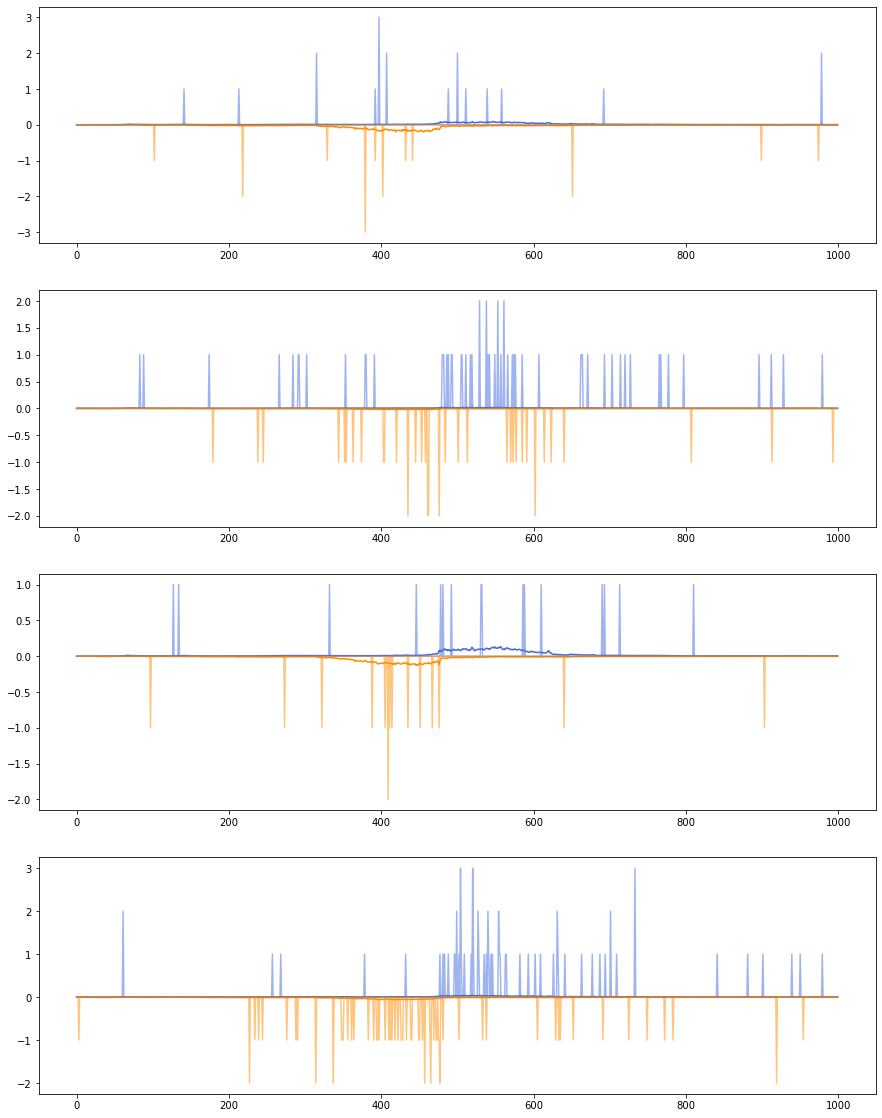

In [73]:
pred_profs, pred_counts, true_profs, true_counts = predict_coords([("chr3", 138875547, 138876547)])
print(profile_binary_auprc(
    true_profs, pred_profs, true_counts, 10,
    bin_prof_min_count, bin_prof_pos_thresh, bin_prof_neg_thresh
))
plot_profiles(pred_profs[0], true_profs[0], normalize=False)

(array([nan, nan, nan, nan]), array([[  0,   0, 200],
       [  0,   0, 200],
       [  0,   0, 200],
       [  0,   0, 200]]))


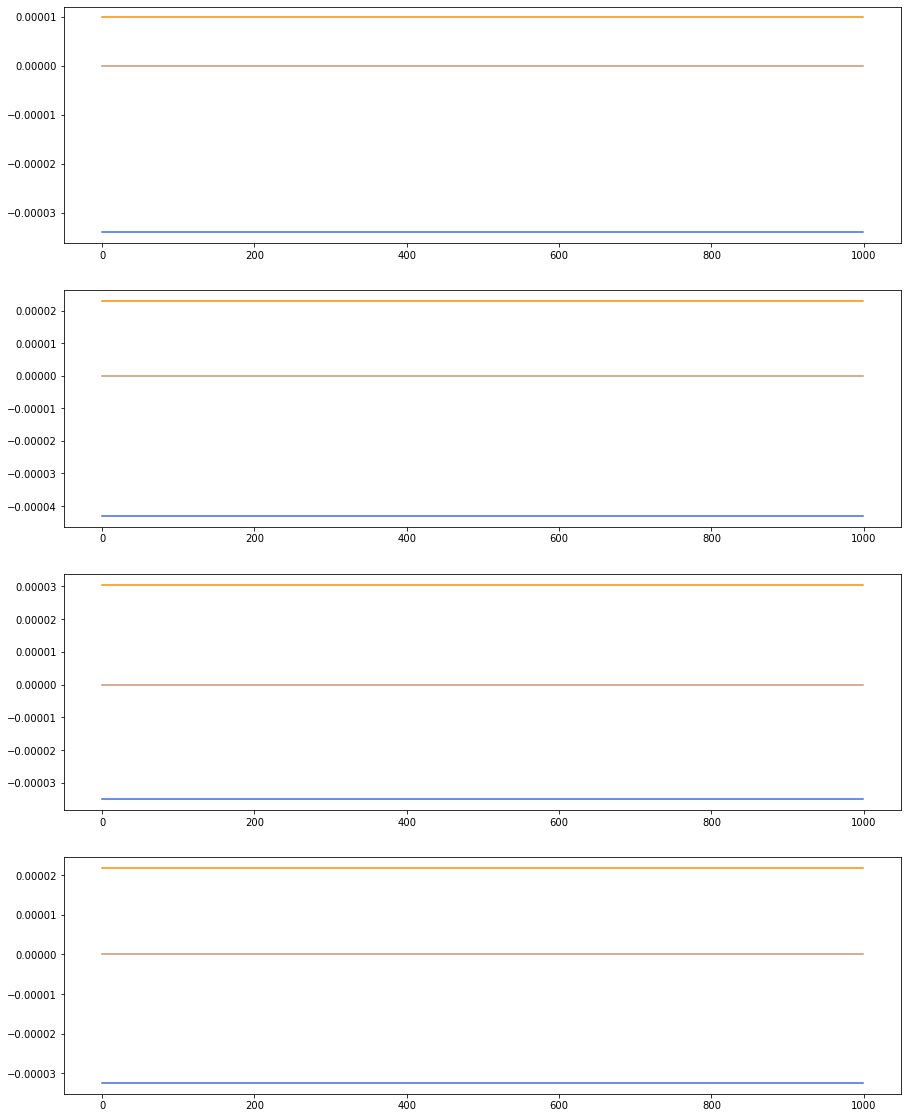

In [79]:
pred_profs, pred_counts, true_profs, true_counts = predict_coords([("chr1", 1000, 2000)])
print(profile_binary_auprc(
    true_profs, pred_profs, true_counts, 10,
    bin_prof_min_count, bin_prof_pos_thresh, bin_prof_neg_thresh
))
plot_profiles(pred_profs[0], true_profs[0], normalize=False)

(array([0.80555556, 1.        , 0.80102041, 1.        ]), array([[  3,  47, 150],
       [ 15,  13, 172],
       [  7,  35, 158],
       [ 20,  45, 135]]))


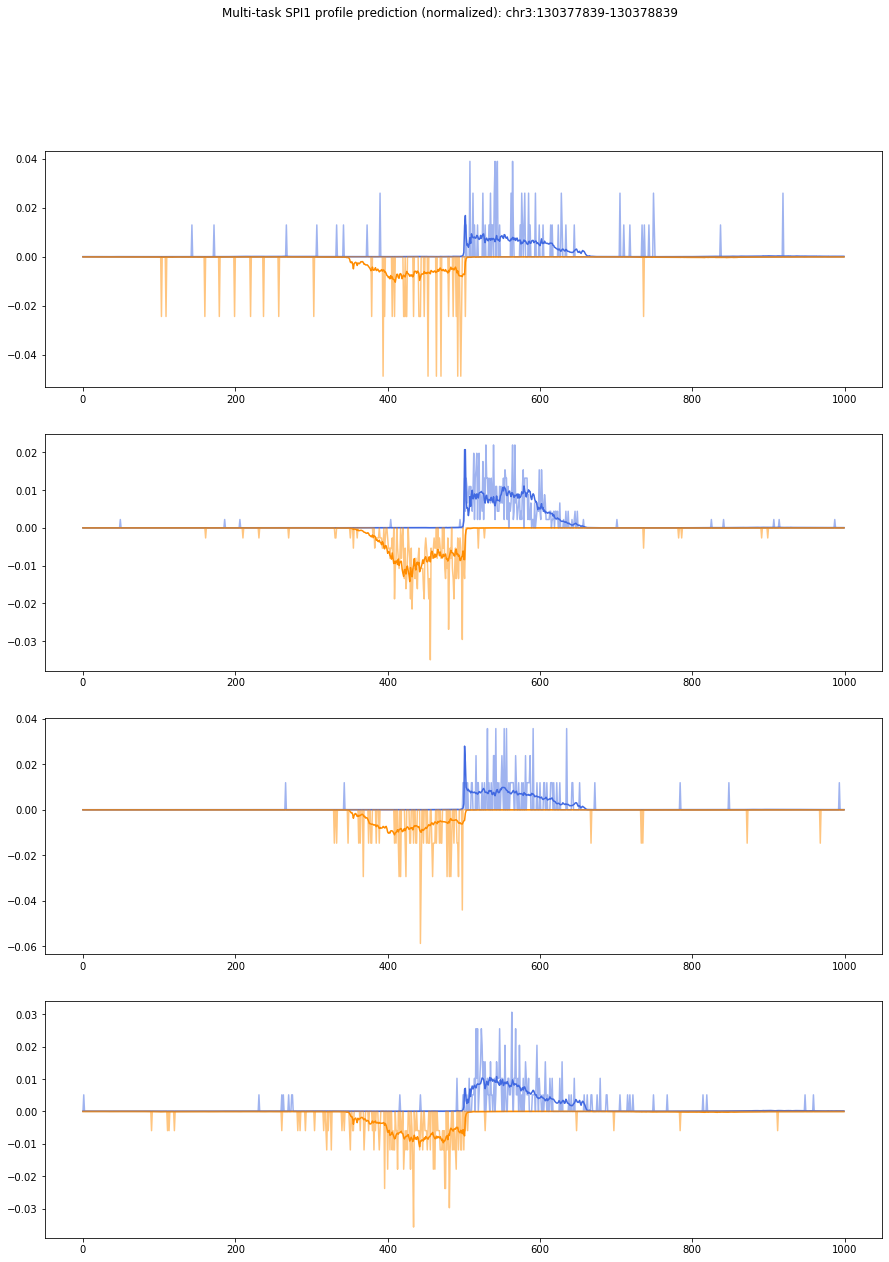

In [81]:
pred_profs, pred_counts, true_profs, true_counts = predict_coords([("chr3", 130377839, 130378839)])
print(profile_binary_auprc(
    true_profs, pred_profs, true_counts, 10,
    bin_prof_min_count, bin_prof_pos_thresh, bin_prof_neg_thresh
))
plot_profiles(pred_profs[0], true_profs[0], title="Multi-task SPI1 profile prediction (normalized): chr3:130377839-130378839")

/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


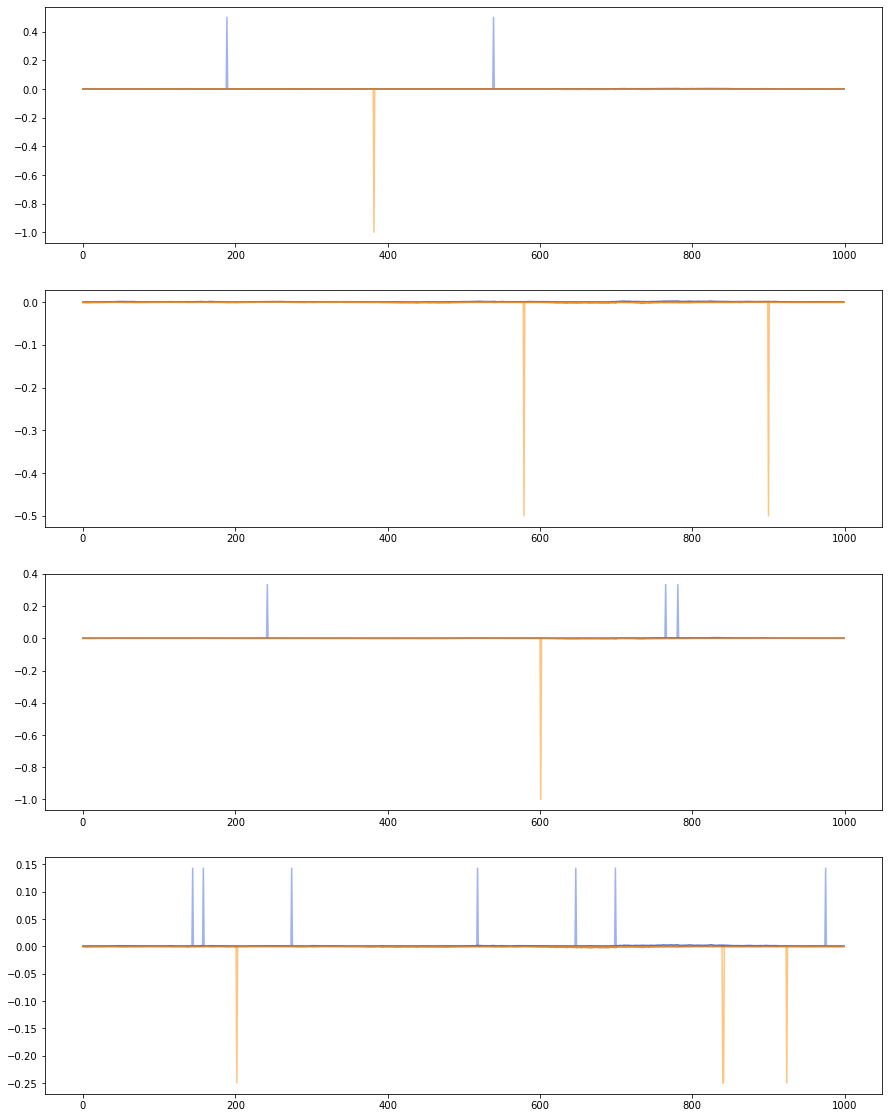

In [83]:
pred_profs, pred_counts, true_profs, true_counts = predict_coords([("chr2", 1000000, 1001000)])
plot_profiles(pred_profs[0], true_profs[0])

In [94]:
all_pos_pred_profs, all_pos_pred_counts, all_pos_true_profs, all_pos_true_counts = \
    predict_coords(pos_coords_table.values[:200])

In [119]:
print(profile_binary_auprc(
    all_pos_true_profs, all_pos_pred_profs, all_pos_true_counts, 1,
    bin_prof_min_count, bin_prof_pos_thresh, bin_prof_neg_thresh
))

(array([0.05267139, 0.10217048, 0.06627647, 0.07683733]), array([[  6959,   3956, 389085],
       [ 10589,   4043, 385368],
       [  7446,   4946, 387608],
       [  8791,   7819, 383390]]))


In [96]:
all_neg_pred_profs, all_neg_pred_counts, all_neg_true_profs, all_neg_true_counts = \
    predict_coords(neg_coord_sampler.sample_intervals(200))

In [103]:
print(profile_binary_auprc(
    all_neg_true_profs, all_neg_pred_profs, all_neg_true_counts, 200,
    bin_prof_min_count, bin_prof_pos_thresh, bin_prof_neg_thresh
))

(array([0.01931443, 0.05262921, 0.02169906, 0.03960266]), array([[  1605,    203, 398192],
       [  1624,     85, 398291],
       [  1662,    198, 398140],
       [  2054,    421, 397525]]))
